In [1]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using Theano backend.


In [2]:
np.random.seed(7)

In [3]:
def read_data(path):
    df = pd.read_csv(path, parse_dates=['FECHA'], infer_datetime_format=True)
    df['CPRECIO'] = df[' CPRECIO '].map(lambda x: x.strip().replace(",", ""))
    df['CPRECIO'] = df['CPRECIO'].convert_objects(convert_numeric=True)
    df['COSTOPESOS'] = df[' COSTOPESOS ']
    df = df.drop([' CPRECIO ', ' COSTOPESOS '], axis=1)
    cols = df.columns.values 
    cols[-3] = "YEAR"
    df.columns = cols
    return df

def read_test_data(path):
    df = pd.read_csv(path, parse_dates=['FECHA'], infer_datetime_format=True)
    df['CPRECIO'] = df[' CPRECIO ']
    df['COSTOPESOS'] = df[' COSTOPESOS ']
    df = df.drop([' CPRECIO ', ' COSTOPESOS '], axis=1)
    cols = df.columns.values 
    cols[-3] = "YEAR"
    df.columns = cols
    return df

def calculate_extra_cols(df):
    df['total_price'] =  df['CPRECIO'] * df['#UNIDADES'] * df['CTIPOCAM01']
    return df

In [91]:
df = read_data('./BASEVENTAS2010A2015.csv')
df = calculate_extra_cols(df)

# Cleanup all the spaces
df["MARCA"] = df["MARCA"].map(lambda x: x.strip())
df["IDPRODUCTO"] = df["IDPRODUCTO"].map(lambda x: x.strip())

/Users/Grimi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [92]:
df = df[df["IDPRODUCTO"] == "25967"]
df = df.set_index("FECHA")
ts = df["#UNIDADES"]
ts = ts.resample("W").mean().sort_index().fillna(0)
ts = ts["2013":]

In [124]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ts.values.reshape(-1, 1))

In [125]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [165]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [166]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=300, batch_size=1, verbose=2)
# for i in range(100):
#     model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
#     model.reset_states()

Epoch 1/300
0s - loss: 0.0281
Epoch 2/300
0s - loss: 0.0246
Epoch 3/300
0s - loss: 0.0247
Epoch 4/300
0s - loss: 0.0244
Epoch 5/300
0s - loss: 0.0247
Epoch 6/300
0s - loss: 0.0245
Epoch 7/300
0s - loss: 0.0246
Epoch 8/300
0s - loss: 0.0248
Epoch 9/300
0s - loss: 0.0248
Epoch 10/300
0s - loss: 0.0244
Epoch 11/300
0s - loss: 0.0243
Epoch 12/300
0s - loss: 0.0243
Epoch 13/300
0s - loss: 0.0245
Epoch 14/300
0s - loss: 0.0242
Epoch 15/300
0s - loss: 0.0242
Epoch 16/300
0s - loss: 0.0244
Epoch 17/300
0s - loss: 0.0240
Epoch 18/300
0s - loss: 0.0242
Epoch 19/300
0s - loss: 0.0247
Epoch 20/300
0s - loss: 0.0239
Epoch 21/300
0s - loss: 0.0245
Epoch 22/300
0s - loss: 0.0241
Epoch 23/300
0s - loss: 0.0242
Epoch 24/300
0s - loss: 0.0240
Epoch 25/300
0s - loss: 0.0239
Epoch 26/300
0s - loss: 0.0243
Epoch 27/300
0s - loss: 0.0239
Epoch 28/300
0s - loss: 0.0241
Epoch 29/300
0s - loss: 0.0242
Epoch 30/300
0s - loss: 0.0239
Epoch 31/300
0s - loss: 0.0240
Epoch 32/300
0s - loss: 0.0241
Epoch 33/300
0s -

In [167]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
model.reset_states()
print('Train Score: ', scaler.inverse_transform(np.array([[trainScore]])))
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
model.reset_states()
print('Test Score: ', scaler.inverse_transform(np.array([[testScore]])))

('Train Score: ', array([[ 0.98589662]]))
('Test Score: ', array([[ 0.5520764]]))


In [168]:
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
model.reset_states()

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

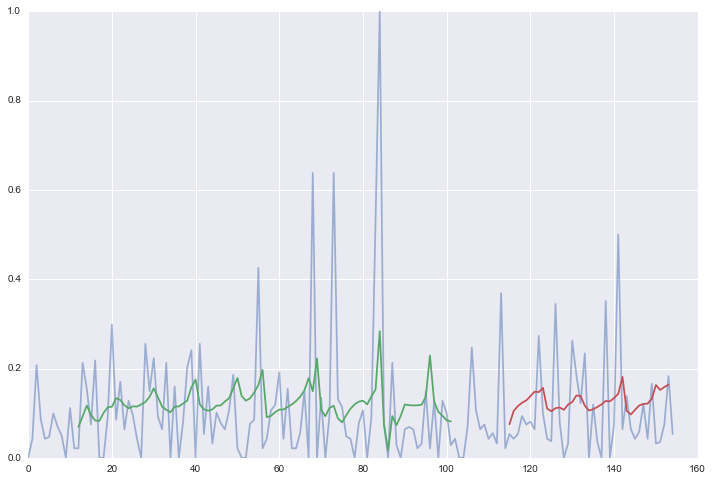

In [169]:
# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(dataset, alpha=0.5)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

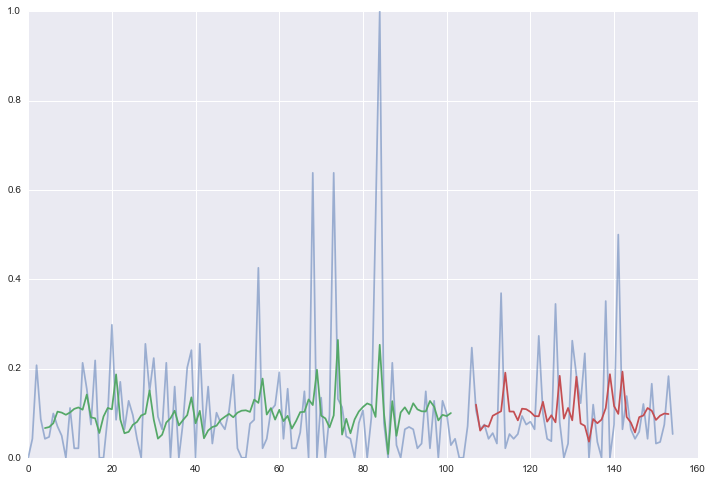

In [158]:
# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(dataset, alpha=0.5)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)